<a href="https://colab.research.google.com/github/agpascoe/NN_experiments/blob/main/Pytorch/GAN_MNIST_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [21]:
torch.__version__

'1.12.1+cu113'

In [22]:
#this is a visualization function
def show_images(input, channel=1, size=(28,28), sizegrid=6):
  #The imput is a vector of (samples, size), that is a comprossed nxn image (784 in this example)
  data = input.detach().cpu().view(-1, channel, *size) # move from (samples,nxn) vector to a (samples, 1, n, n) and move it to a CPU
  grid = make_grid(tensor=data[:sizegrid**2], nrow=sizegrid, padding=False).permute(1,2,0) # create a sizegrid x sizegrid grid ready for being plot (permute)
 
  print(data.shape, grid.shape)
  plt.imshow(grid)
  plt.show()



In [23]:



# HyperParameters
EPOCHS = 500
INFO_STEP = 500
ZDIM = 64
LR = 1e-5
BATCHSIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATALOADER = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=BATCHSIZE)


torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


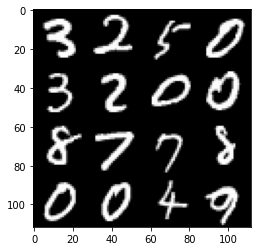

In [24]:
x, y = next(iter(DATALOADER))
show_images(x.view(-1,784))

In [25]:
#Noise generator
def noiseGenerator(nVectors, zDim):
  return torch.randn(nVectors, zDim).to(DEVICE)


In [26]:
from torch.nn.modules.activation import ReLU
#defining two models, Generator and Discriinator

def generatorBlock(input, output):
  return nn.Sequential(
      nn.Linear(input, output),
      nn.BatchNorm1d(output),
      nn.ReLU(inplace=True) #optimize memory because makes the operation directly
  )

class generatorClass(nn.Module):
  def __init__(self, zDim, hiddenDim, outputDim):
    super().__init__()
    self.gen = nn.Sequential(
        generatorBlock(zDim, hiddenDim),
        generatorBlock(hiddenDim, 2*hiddenDim),
        generatorBlock(2*hiddenDim, 4*hiddenDim),
        generatorBlock(4*hiddenDim, 8*hiddenDim),
        nn.Linear(8*hiddenDim, outputDim),
        nn.Sigmoid(),
    )
    self.optimizer = torch.optim.Adam(self.parameters(), lr = LR)
  
  def forward(self, noise):
    return self.gen(noise)


def discriminatorBlock(input, output):
  return nn.Sequential(
      nn.Linear(input, output),
      nn.LeakyReLU(0.02) #The size of the slope is 0.2
  )

class discriminatorClass(nn.Module):
  def __init__(self,inputDim):
    super().__init__()
    self.disc = nn.Sequential(
        discriminatorBlock(inputDim, int(inputDim/2)),
        discriminatorBlock(int(inputDim/2), int(inputDim/4)),
        discriminatorBlock(int(inputDim/4), int(inputDim/8)),
        nn.Linear(int(inputDim/8),1)
    )
    self.optimizer = torch.optim.Adam(self.parameters(), lr = LR)


  def forward(self, image):
    return self.disc(image)


In [27]:
#defining a GAN
class ganClass(nn.Module):
  def __init__(self, zDim, hiddenGenDim, inputDiscDim):
    super().__init__()
    self.generator = generatorClass(zDim, hiddenGenDim, inputDiscDim)
    self.discriminator = discriminatorClass(inputDiscDim)
    self.lossFunction = nn.BCEWithLogitsLoss()

  def forward(self, noise):
    return self.discriminator(self.generator(noise))

  def lossGenCalculation(self, number, zDim):
    preds = self.discriminator(self.generator(noiseGenerator(number, zDim)))
    return self.lossFunction(preds, torch.ones_like(preds).to(DEVICE))
  
  def lossDiscCalculation(self, number, zDim, real):
    discFake = self.discriminator(self.generator(noiseGenerator(number, zDim)).detach())
    discFakeLoss = self.lossFunction(discFake, torch.zeros_like(discFake).to(DEVICE))
    discReal = self.discriminator(real)
    discRealLoss = self.lossFunction(discReal, torch.ones_like(discReal).to(DEVICE))
    return (discFakeLoss+discRealLoss)/2

  def fit(self, zDim, dataloader=DATALOADER, epochs = EPOCHS):
    
    #Setup main parameters
    currentStep = 0
    currentBatchSize = 0
    meanGeneratorLoss = 0
    meanDiscrtiminatorLoss = 0

    
    for epoch in range(epochs):
      for real, _ in tqdm(dataloader):
        #trainning discriminator
        real=real.to(DEVICE)
        self.discriminator.optimizer.zero_grad()
        currentBatchSize = len(real)
        real = real.view(currentBatchSize, -1) #resizes to 128 x xx for example
        discLoss = self.lossDiscCalculation(currentBatchSize, zDim, real)
        discLoss.backward(retain_graph=True)
        self.discriminator.optimizer.step()


        #trainning generator
        self.generator.optimizer.zero_grad()
        genLoss = self.lossGenCalculation(currentBatchSize,zDim)
        genLoss.backward(retain_graph=True)
        self.generator.optimizer.step()

        meanDiscrtiminatorLoss+= discLoss.item() / INFO_STEP
        meanGeneratorLoss += genLoss.item() / INFO_STEP
        if currentStep % INFO_STEP == 0 and currentStep>0:
          fake = self.generator(noiseGenerator(currentBatchSize, zDim))
          show_images(fake)
          print(f'{epoch}, step: {currentStep}, MeanDiscLoss: {meanDiscrtiminatorLoss}, GenDiscLoss: {meanGeneratorLoss}')
          meanGeneratorLoss, meanDiscrtiminatorLoss = 0,0
        currentStep+= 1  





  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


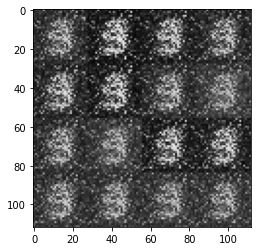

0, step: 300, MeanDiscLoss: 0.554683988591035, GenDiscLoss: 0.917776179909707


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


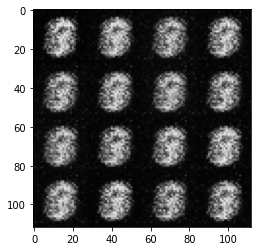

1, step: 600, MeanDiscLoss: 0.3843106930454572, GenDiscLoss: 1.3817835195859278
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


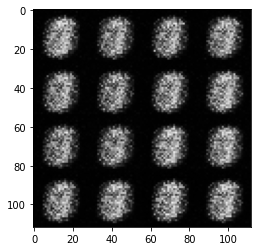

1, step: 900, MeanDiscLoss: 0.4247430399060247, GenDiscLoss: 1.3179605925083169


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


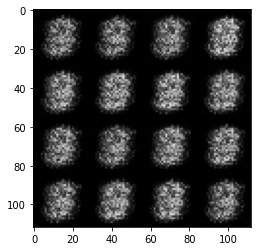

2, step: 1200, MeanDiscLoss: 0.3534790820876757, GenDiscLoss: 1.371925175587337


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


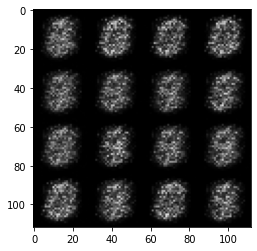

3, step: 1500, MeanDiscLoss: 0.3062224866946538, GenDiscLoss: 1.3860688710212705
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


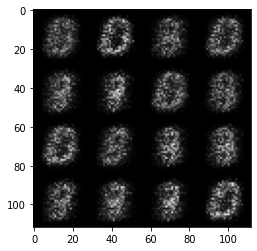

3, step: 1800, MeanDiscLoss: 0.3123882849017782, GenDiscLoss: 1.2810834681987762


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


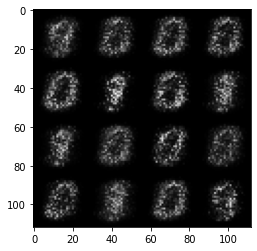

4, step: 2100, MeanDiscLoss: 0.3433129562934236, GenDiscLoss: 1.1563474162419638


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


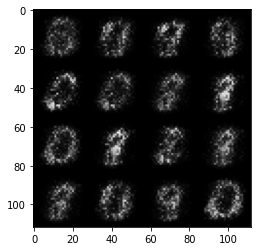

5, step: 2400, MeanDiscLoss: 0.3050043581426145, GenDiscLoss: 1.2207379825909943
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


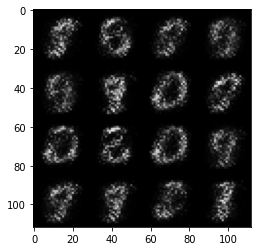

5, step: 2700, MeanDiscLoss: 0.3113279856244724, GenDiscLoss: 1.224981208642324


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


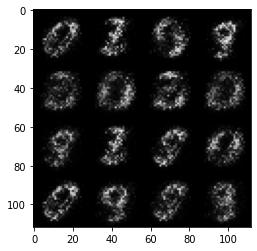

6, step: 3000, MeanDiscLoss: 0.27673951476812353, GenDiscLoss: 1.3494176761309302


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


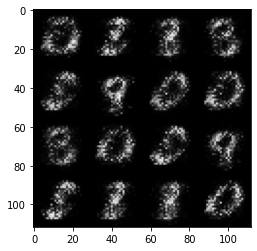

7, step: 3300, MeanDiscLoss: 0.2582774743437767, GenDiscLoss: 1.4754202485084529
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


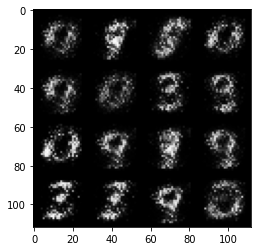

7, step: 3600, MeanDiscLoss: 0.22068818623820938, GenDiscLoss: 1.7571485813458767


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


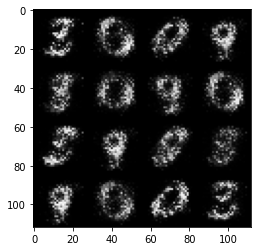

8, step: 3900, MeanDiscLoss: 0.19822811449567465, GenDiscLoss: 1.9045081265767405
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


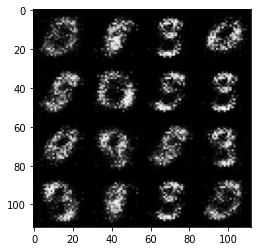

8, step: 4200, MeanDiscLoss: 0.16821719626585624, GenDiscLoss: 2.158845727046332


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


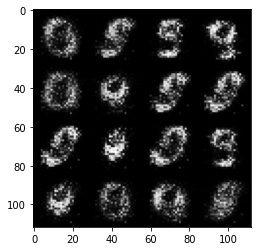

9, step: 4500, MeanDiscLoss: 0.16379522395630672, GenDiscLoss: 2.2580085929234817


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


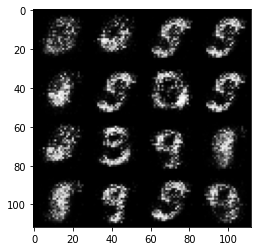

10, step: 4800, MeanDiscLoss: 0.14811985711256664, GenDiscLoss: 2.584822001457214
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


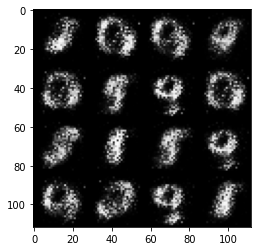

10, step: 5100, MeanDiscLoss: 0.1557610235114893, GenDiscLoss: 2.5832999491691586


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


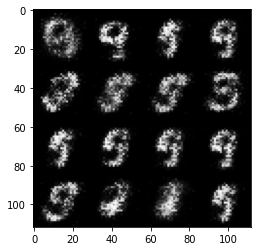

11, step: 5400, MeanDiscLoss: 0.13809296225508058, GenDiscLoss: 2.727781630357104


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


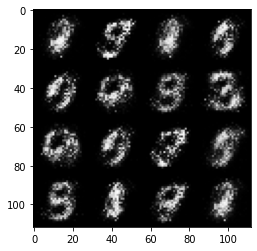

12, step: 5700, MeanDiscLoss: 0.1559152380128702, GenDiscLoss: 2.5650558153788237
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


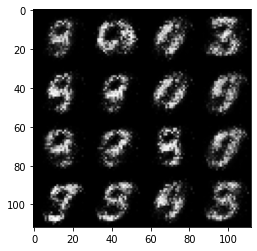

12, step: 6000, MeanDiscLoss: 0.14177648405234017, GenDiscLoss: 2.782869793574015


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


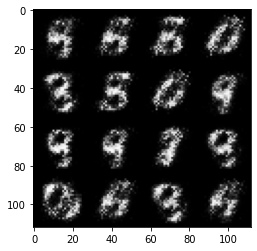

13, step: 6300, MeanDiscLoss: 0.13362615391612057, GenDiscLoss: 2.6825504533449838


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


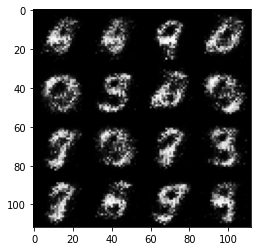

14, step: 6600, MeanDiscLoss: 0.1156709676484267, GenDiscLoss: 2.8208471854527795
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


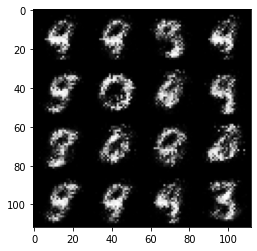

14, step: 6900, MeanDiscLoss: 0.09229981678227588, GenDiscLoss: 3.0127391401926684


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


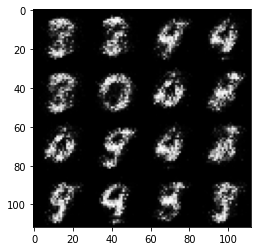

15, step: 7200, MeanDiscLoss: 0.0939077637096246, GenDiscLoss: 3.0725552431742345
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


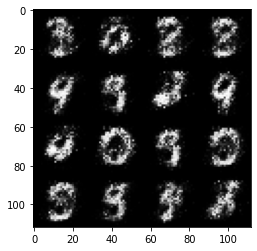

15, step: 7500, MeanDiscLoss: 0.09375620727737745, GenDiscLoss: 3.081508054733275


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


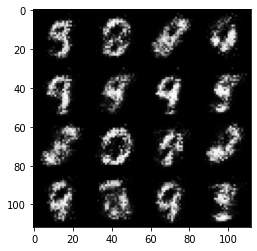

16, step: 7800, MeanDiscLoss: 0.09501458028952285, GenDiscLoss: 3.107075190544129


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


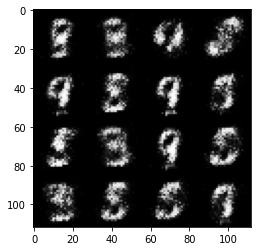

17, step: 8100, MeanDiscLoss: 0.10196250090996421, GenDiscLoss: 3.203120196660362
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


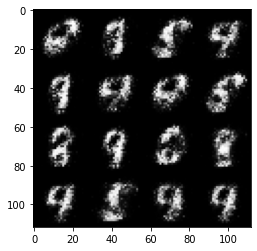

17, step: 8400, MeanDiscLoss: 0.10372018231699864, GenDiscLoss: 3.0746220731735225


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


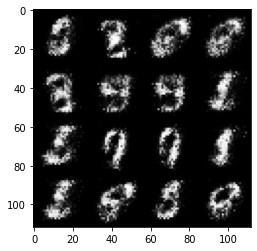

18, step: 8700, MeanDiscLoss: 0.09776997604717806, GenDiscLoss: 3.2776950001716614


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


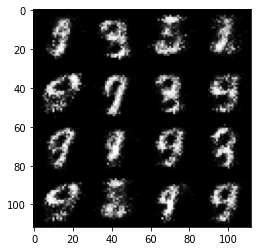

19, step: 9000, MeanDiscLoss: 0.08799548952529829, GenDiscLoss: 3.444561661084491
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


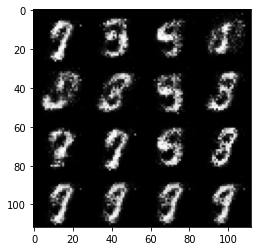

19, step: 9300, MeanDiscLoss: 0.10570583064109092, GenDiscLoss: 3.318650081157684


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


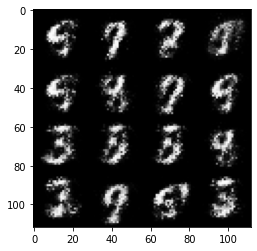

20, step: 9600, MeanDiscLoss: 0.10386818150679272, GenDiscLoss: 3.2477274425824483


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


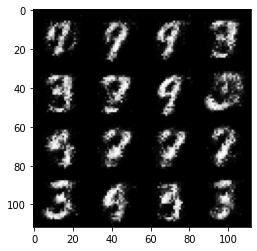

21, step: 9900, MeanDiscLoss: 0.11250875718891626, GenDiscLoss: 3.159296242396038
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


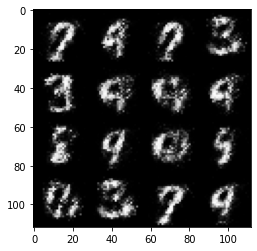

21, step: 10200, MeanDiscLoss: 0.1212854129821063, GenDiscLoss: 3.173339037100473


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


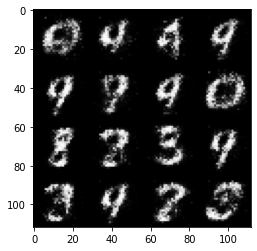

22, step: 10500, MeanDiscLoss: 0.12148565448820599, GenDiscLoss: 3.137656791210175


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


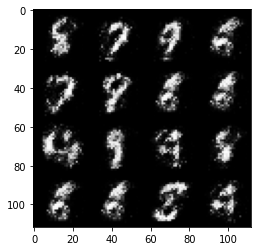

23, step: 10800, MeanDiscLoss: 0.12165573216974726, GenDiscLoss: 3.1136499460538234
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


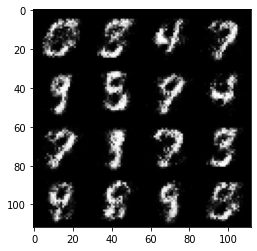

23, step: 11100, MeanDiscLoss: 0.11855234762032822, GenDiscLoss: 3.2145377508799204


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


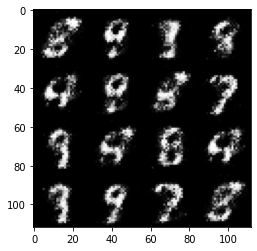

24, step: 11400, MeanDiscLoss: 0.1235486726214488, GenDiscLoss: 3.1579494825998937
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


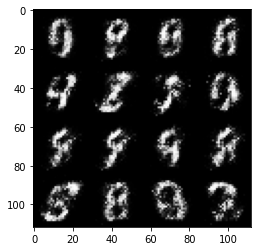

24, step: 11700, MeanDiscLoss: 0.11492196048299477, GenDiscLoss: 3.2737498561541227


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


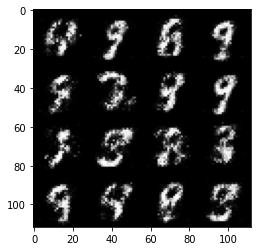

25, step: 12000, MeanDiscLoss: 0.11964626222848895, GenDiscLoss: 3.1912534205118837


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


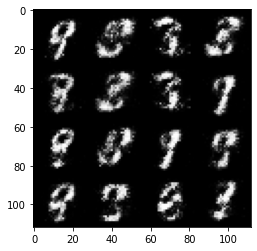

26, step: 12300, MeanDiscLoss: 0.11694839378197983, GenDiscLoss: 3.2155167579650885
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


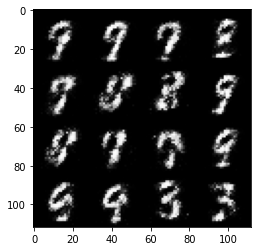

26, step: 12600, MeanDiscLoss: 0.1232192428658406, GenDiscLoss: 3.2376765354474397


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


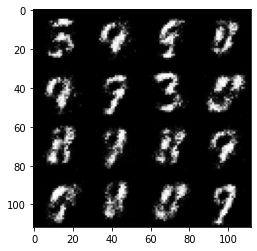

27, step: 12900, MeanDiscLoss: 0.12391106143593796, GenDiscLoss: 3.1092963449160247


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


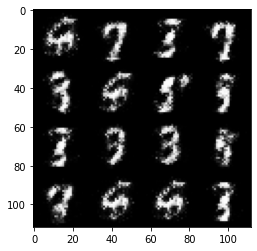

28, step: 13200, MeanDiscLoss: 0.13248605700830623, GenDiscLoss: 3.0268346341451013
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


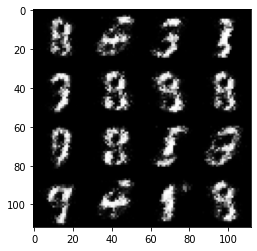

28, step: 13500, MeanDiscLoss: 0.12968851059675215, GenDiscLoss: 3.2046918678283696


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


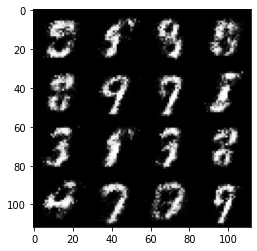

29, step: 13800, MeanDiscLoss: 0.13381988535324732, GenDiscLoss: 3.138921703497569


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


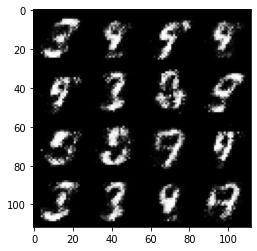

30, step: 14100, MeanDiscLoss: 0.13003687577943007, GenDiscLoss: 3.200083095232649
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


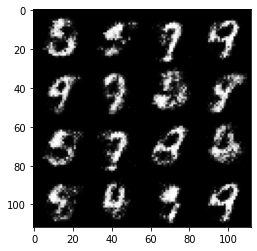

30, step: 14400, MeanDiscLoss: 0.14292161983748278, GenDiscLoss: 3.095470724900565


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


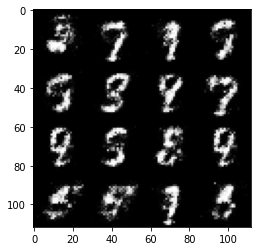

31, step: 14700, MeanDiscLoss: 0.1317796472460032, GenDiscLoss: 3.146463042100269
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


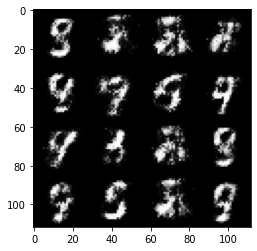

31, step: 15000, MeanDiscLoss: 0.12774233157436055, GenDiscLoss: 3.191829452514649


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


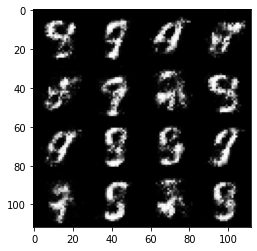

32, step: 15300, MeanDiscLoss: 0.12815259965757533, GenDiscLoss: 3.2269608251253765


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


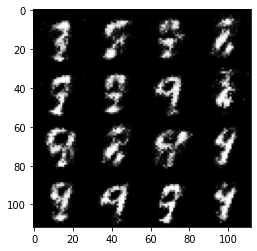

33, step: 15600, MeanDiscLoss: 0.1538889042784771, GenDiscLoss: 3.207323824564618
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


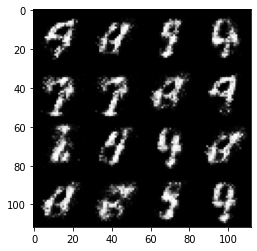

33, step: 15900, MeanDiscLoss: 0.1637741250793139, GenDiscLoss: 3.06192173163096


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


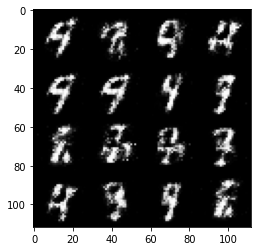

34, step: 16200, MeanDiscLoss: 0.1486240082730849, GenDiscLoss: 3.020521364212036


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


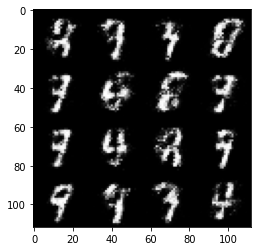

35, step: 16500, MeanDiscLoss: 0.16835687287151815, GenDiscLoss: 2.9793035054206847
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


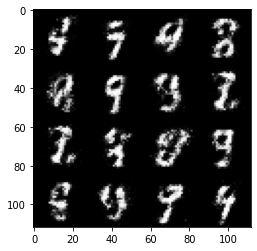

35, step: 16800, MeanDiscLoss: 0.17403180276354155, GenDiscLoss: 2.873243910471597


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


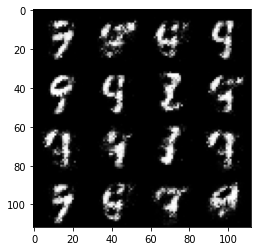

36, step: 17100, MeanDiscLoss: 0.17304319327076276, GenDiscLoss: 2.8617640606562293


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


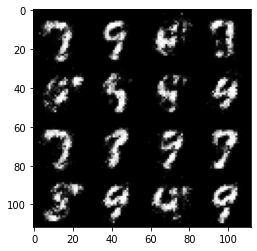

37, step: 17400, MeanDiscLoss: 0.15690187816818557, GenDiscLoss: 2.9009235803286226
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


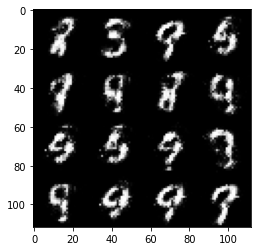

37, step: 17700, MeanDiscLoss: 0.17470336397488906, GenDiscLoss: 2.8416876196861303


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


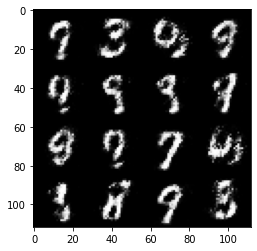

38, step: 18000, MeanDiscLoss: 0.16860533567766348, GenDiscLoss: 2.876047075589496


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


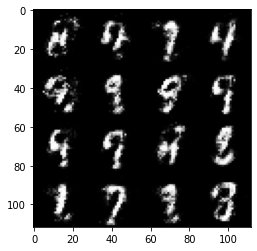

39, step: 18300, MeanDiscLoss: 0.1951582875351111, GenDiscLoss: 2.77553125222524
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


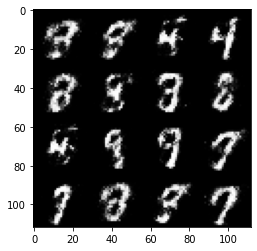

39, step: 18600, MeanDiscLoss: 0.19487376108765608, GenDiscLoss: 2.7807530593872083


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


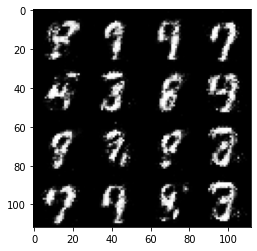

40, step: 18900, MeanDiscLoss: 0.15912598840892314, GenDiscLoss: 2.8971621116002404
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


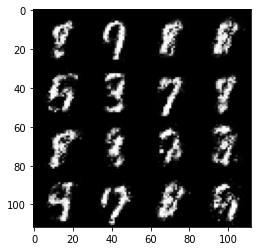

40, step: 19200, MeanDiscLoss: 0.16033842869102943, GenDiscLoss: 2.9879872290293363


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


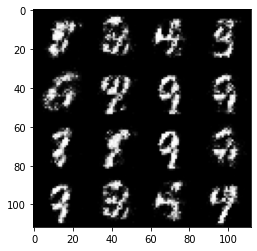

41, step: 19500, MeanDiscLoss: 0.20337150447070582, GenDiscLoss: 2.809875090122223


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


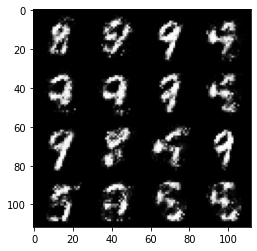

42, step: 19800, MeanDiscLoss: 0.2424421150485673, GenDiscLoss: 2.6201914525032057
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


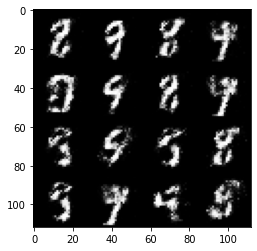

42, step: 20100, MeanDiscLoss: 0.20161451975504557, GenDiscLoss: 2.6613513716061914


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


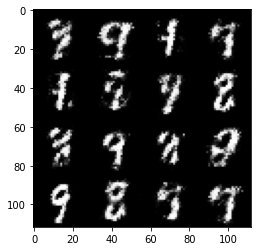

43, step: 20400, MeanDiscLoss: 0.20921141751110559, GenDiscLoss: 2.676351646582287


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


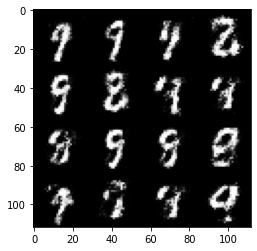

44, step: 20700, MeanDiscLoss: 0.20574765046437568, GenDiscLoss: 2.7006687331199646
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


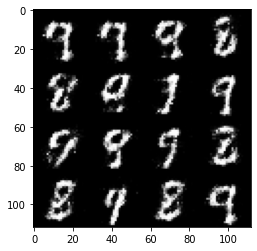

44, step: 21000, MeanDiscLoss: 0.19012563675642014, GenDiscLoss: 2.7184042429924022


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


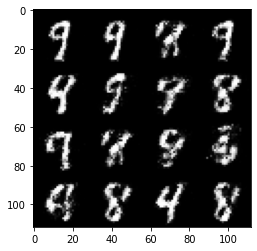

45, step: 21300, MeanDiscLoss: 0.20735034036139632, GenDiscLoss: 2.6912548240025833


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


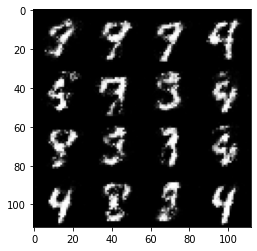

46, step: 21600, MeanDiscLoss: 0.21308680941661212, GenDiscLoss: 2.583147682348887
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


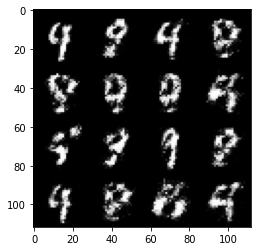

46, step: 21900, MeanDiscLoss: 0.22977076088388765, GenDiscLoss: 2.549525187015533


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


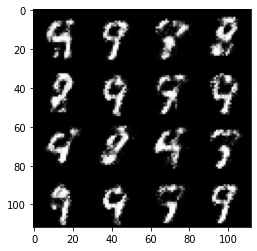

47, step: 22200, MeanDiscLoss: 0.2198067431648572, GenDiscLoss: 2.500983576774597
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


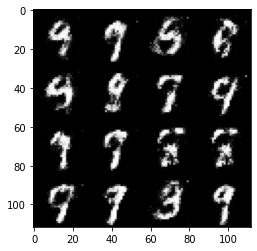

47, step: 22500, MeanDiscLoss: 0.22199299340446793, GenDiscLoss: 2.6356027221679685


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


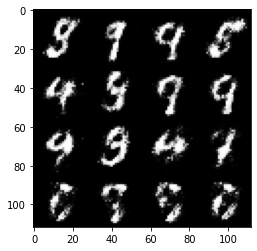

48, step: 22800, MeanDiscLoss: 0.2379939097166061, GenDiscLoss: 2.496711970965068


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


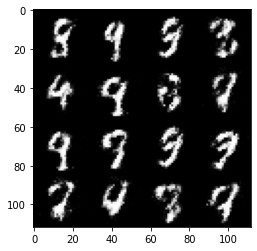

49, step: 23100, MeanDiscLoss: 0.21005775074164074, GenDiscLoss: 2.4551775288581856
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


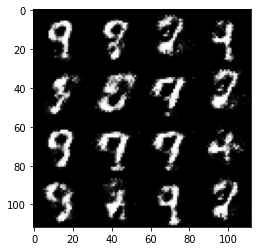

49, step: 23400, MeanDiscLoss: 0.21921810805797576, GenDiscLoss: 2.5704901758829752


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


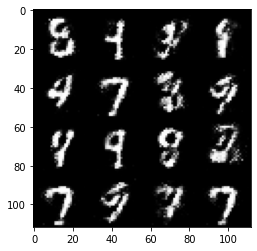

50, step: 23700, MeanDiscLoss: 0.23048006157080334, GenDiscLoss: 2.50739604671796


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


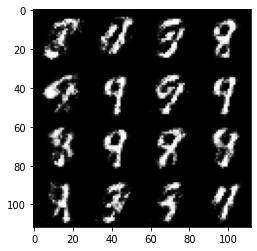

51, step: 24000, MeanDiscLoss: 0.22156511788566915, GenDiscLoss: 2.472433706919352
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


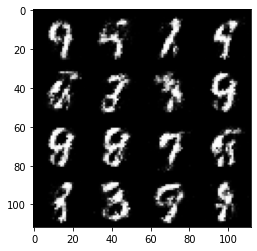

51, step: 24300, MeanDiscLoss: 0.21656961813569062, GenDiscLoss: 2.5178135816256186


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


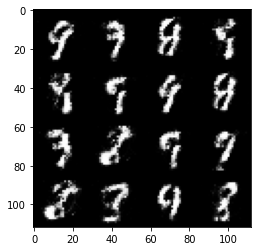

52, step: 24600, MeanDiscLoss: 0.21935924150049674, GenDiscLoss: 2.4876249965031936


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


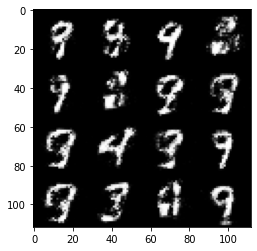

53, step: 24900, MeanDiscLoss: 0.22474198202292134, GenDiscLoss: 2.52925888299942
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


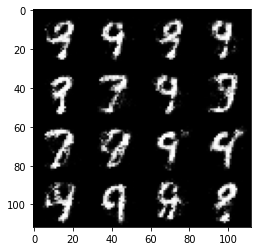

53, step: 25200, MeanDiscLoss: 0.22380912219484642, GenDiscLoss: 2.5217299898465466


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


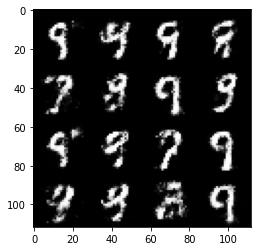

54, step: 25500, MeanDiscLoss: 0.22354358593622842, GenDiscLoss: 2.5834991757074985


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


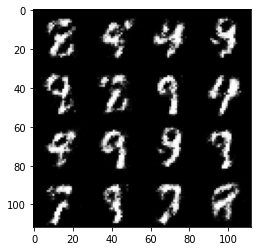

55, step: 25800, MeanDiscLoss: 0.24728564913074172, GenDiscLoss: 2.4531138300895705
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


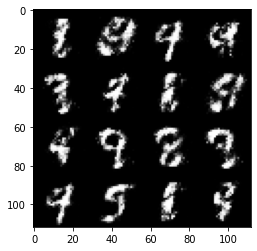

55, step: 26100, MeanDiscLoss: 0.2479546369612216, GenDiscLoss: 2.3841758195559173


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


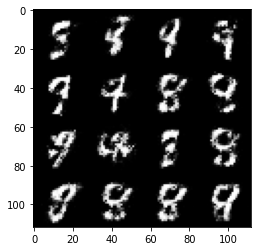

56, step: 26400, MeanDiscLoss: 0.2624793445070585, GenDiscLoss: 2.371604096492133
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


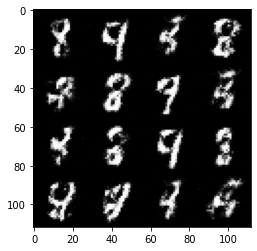

56, step: 26700, MeanDiscLoss: 0.24193571314215678, GenDiscLoss: 2.4264580225944505


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


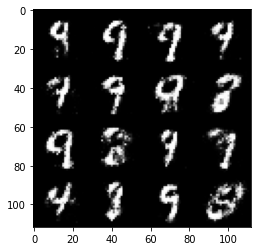

57, step: 27000, MeanDiscLoss: 0.2365821005403994, GenDiscLoss: 2.445846985975903


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


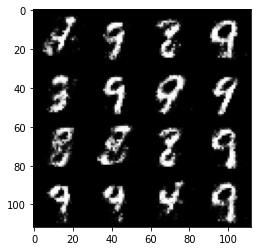

58, step: 27300, MeanDiscLoss: 0.2506444666286307, GenDiscLoss: 2.3952967921892805
torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


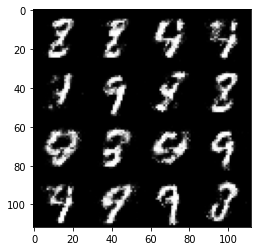

58, step: 27600, MeanDiscLoss: 0.26295412530501683, GenDiscLoss: 2.2692845761775953


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


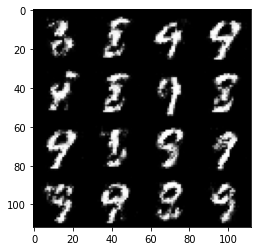

59, step: 27900, MeanDiscLoss: 0.252416459073623, GenDiscLoss: 2.2580139895280205


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28]) torch.Size([112, 112, 3])


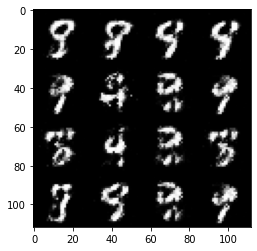

60, step: 28200, MeanDiscLoss: 0.2440235855678717, GenDiscLoss: 2.406421209971109


KeyboardInterrupt: ignored

In [28]:
gan = ganClass(zDim=ZDIM,hiddenGenDim=128,inputDiscDim=784).to(DEVICE)
gan.fit(zDim=ZDIM)